# PPO
---

### 1. Import the Necessary Packages

In [1]:
from model.ppo_3 import PPO
from env.wrappers import *
from env.ant_disturbances import *
from utils.logger import WandbSummaryWritter
import torch
from networks.mlp import MLP, DummyEncoder
from networks.LSTMAdaptiveActorCritic import LSTMAdaptiveActorCritic

### 2. Instantiate the Model

Setup the hyperparameters in the code cell below.

In [2]:
# hyperparameters = {
#     'timesteps_per_batch': 1024 ,                # Number of timesteps to run per batch
#     'max_timesteps_per_episode': 1200,           # Max number of timesteps per episode
#     'n_updates_per_iteration': 5,                # Number of times to update actor/critic per iteration
#     'lr': 2.5e-4 ,                                # Learning rate of actor optimizer
#     'gamma': 0.95,                               # Discount factor to be applied when calculating Rewards-To-Go
# }
# hyperparameters = {'gamma': 0.999, 'lr_gamma': 0.995,
#                    'max_timesteps_per_episode': 1200,'lr': 0.005 }

hyperparameters = {}

misc_hyperparameters = {
    'env': Ant,
    'activation': torch.nn.ReLU,
    'base_encoder_class': MLP,
    # 'adaptive_class': LSTMAdaptiveActorCritic,
    'env_args': {
        'env_class': Ant_Stiffness,
        'known_disturbances':True,
        'min_stiff':0,
        'max_stiff':10,
    }
}

Initialise wandb session in the code cell below.

In [3]:
LOG = False
if LOG:
    logger = WandbSummaryWritter(project='ant', config =misc_hyperparameters['env']().load_hyperparameters())
else:
    logger=None

Initialise the model fo the desired timestamps. Alternatively can specify a checkpoint to continue training.

In [4]:
checkpoint = 'ppo_checkpoints/ant_test2'
# checkpoint = 'ppo_checkpoints/ant-1'
LOAD_MODEL = False

ppo = PPO(logger, **hyperparameters, **misc_hyperparameters)

if LOAD_MODEL:
    ppo.policy.load_state_dict(torch.load(checkpoint + "/base.pth"))
    # ppo.adpt_module.load_state_dict(torch.load(checkpoint + "/adp_model.pth"))
    # ppo.adapt_policy.set_policy(ppo.policy)

RuntimeError: No CUDA GPUs are available

### 3. Train the Model

Train model for specified amount of timestamps.

In [ ]:
ppo.train()
# ppo.train_adaptive_module()


-------------------- Iteration 1/2500 --------------------
Average Episodic Return: -305.18
Average Actor Loss: -0.15511
Average Critic Loss: 810.276982456635
Average KL Divergence: 0.0097398631797848
Iteration took: 18.74 secs, of which rollout took 16.19 secs and gradient updates took 2.54 secs
Current learning rate: 0.001
------------------------------------------------------


-------------------- Iteration 2/2500 --------------------
Average Episodic Return: -278.85
Average Actor Loss: -0.15321
Average Critic Loss: 661.9864070100539
Average KL Divergence: 0.009274855853152651
Iteration took: 18.07 secs, of which rollout took 16.15 secs and gradient updates took 1.91 secs
Current learning rate: 0.001
------------------------------------------------------


-------------------- Iteration 3/2500 --------------------
Average Episodic Return: -279.03
Average Actor Loss: -0.1517
Average Critic Loss: 664.4922528223954
Average KL Divergence: 0.009190789827286248
Iteration took: 17.94 sec

### 4. Evaluate the Model

Run multiple episodes from pretrained model.

In [ ]:
import os
i = 1
path = f"./trained_models/"
os.makedirs(path, exist_ok=True)
torch.save(ppo.policy.state_dict(), path + "base.pth")
torch.save(ppo.adpt_module.state_dict(), path + "adpt.pth")
# ppo.test(False)

In [ ]:

import numpy as np
MAX_IT = 25
val_t = np.zeros(MAX_IT)
val_rew = np.zeros(MAX_IT)
ppo.policy.cpu()
env = ppo.env_class(num_envs=1, **ppo.env_args)
for i in  range(0, MAX_IT):
        obs, done = env.reset()
        model = env.envs[0].model
        t = 1
        reward = 0
        while not done[0] and t < 5000:
            action = ppo.policy.sample_action(torch.Tensor(obs))
            obs, rew, done = env.step(action.numpy())
            t+=1
            reward+=rew
        val_t[i] = t
        val_rew[i] =reward
print(np.mean(val_t), np.mean(val_rew))
#752.86 1538.6648483656134

/tmp/ipykernel_70363/2592086886.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_rew[i] =reward


891.44 545.9813212530115


In [ ]:
# import os
# os.environ["MUJOCO_GL"] = "wgl"
# env.close()
# ppo.policy.cpu()
# env = ppo.env_class(num_envs=1, **ppo.env_args)
# while True:
#     obs, done = env.reset()
#     model = env.envs[0].model
#     t = 1
#     while not done[0] and t < 1_000:
#         action = ppo.policy.sample_action(torch.Tensor(obs))
#         obs, _, done = env.step(action.numpy())
#         t+=1

In [ ]:
ppo.adapt_policy.clear_history()

wind_vals = []
base_z = []
adpt_z = []
ppo.policy.to(ppo.device)
env = ppo.env_class(num_envs=1, **ppo.env_args)
obs, done = env.reset()

reward = 0
t = 0
while not done[0] and t < 1_000:
    wind_vals.append(obs[0, -1])

    obs_tensor = torch.tensor(obs, dtype=torch.float32).to(ppo.device)
    action,_ = ppo.adapt_policy.sample_action(obs_tensor)

    base_output = ppo.policy.encoder(obs_tensor).detach().cpu().numpy().flatten()[0]
    adpt_output = ppo.adapt_policy.encode(obs_tensor).detach().cpu().numpy().squeeze()[-1]
    base_z.append(base_output)
    adpt_z.append(adpt_output)
    obs, rew, done = env.step(action.cpu().numpy())
    reward += rew
    t+=1
    if t % 1000 == 0:
        print(t, reward)
print(t, reward)
print(wind_vals[0], base_z[0])

1000 [141.63781824]
1000 [141.63781824]
2.542382901877158 0.02679541


In [ ]:
from scipy.spatial.distance import euclidean, cityblock, cosine

ppo.adapt_policy.clear_history()

wind_vals = []
base_z = []
adpt_z = []
ppo.policy.to(ppo.device)
env = ppo.env_class(num_envs=1, **ppo.env_args)
obs, done = env.reset()

reward = 0
t = 0
while not done[0] and t < 1_000:
    wind_vals.append(obs[0, -1])

    obs_tensor = torch.tensor(obs, dtype=torch.float32).to(ppo.device)
    action,_ = ppo.adapt_policy.sample_action(obs_tensor)

    base_output = ppo.policy.encoder(obs_tensor).detach().cpu().numpy().squeeze()
    adpt_output = ppo.adapt_policy.encode(obs_tensor).detach().cpu().numpy().squeeze()[-10:]
    base_z.append(base_output)
    adpt_z.append(adpt_output)

    # print(base_output - adpt_output)

    obs, rew, done = env.step(action.cpu().numpy())
    reward += rew
    t+=1
    if t % 1000 == 0:
        print(t, reward)
print(t, reward)
# print(wind_vals[0], base_z[0])
print(base_z[0])
print(adpt_z[0])
print(euclidean(base_z[0].squeeze(), adpt_z[0]))

1000 [166.68249829]
1000 [166.68249829]
[ 0.20091514  0.24785838  0.2184565   0.61733776  0.8983991  -0.7831548
  1.         -0.99998033 -0.9427375   0.99959177]
[ 4.1873317   0.31042045 -1.187232    1.9974128   0.92128116 -0.44803673
  1.012028    2.6188648   1.283542    0.88059986]
6.160802841186523


[6.160802841186523, 6.6483941078186035, 6.444781303405762, 6.816652774810791, 6.4270339012146, 5.813990116119385, 6.123539447784424, 5.734130382537842, 6.731051445007324, 6.716711521148682, 6.359954357147217, 6.287628650665283, 6.219539165496826, 5.493816375732422, 6.0539350509643555, 5.27706241607666, 6.573830604553223, 6.576295375823975, 6.168610095977783, 5.864082336425781, 5.67441463470459, 5.382458686828613, 5.502983570098877, 5.894480228424072, 5.598578453063965, 4.818933010101318, 4.573572158813477, 4.229569911956787, 4.267578125, 4.842165946960449, 4.236138343811035, 4.15110969543457, 4.876783847808838, 3.8219263553619385, 4.144620895385742, 3.774998664855957, 3.809628486633301, 3.676570177078247, 3.653902292251587, 3.6521074771881104, 4.442471981048584, 4.254445552825928, 4.348393440246582, 4.503068923950195, 5.546156883239746, 4.374760627746582, 4.853339672088623, 4.8190131187438965, 4.80168342590332, 5.625276565551758, 5.921607971191406, 4.999676704406738, 5.436837196350098,

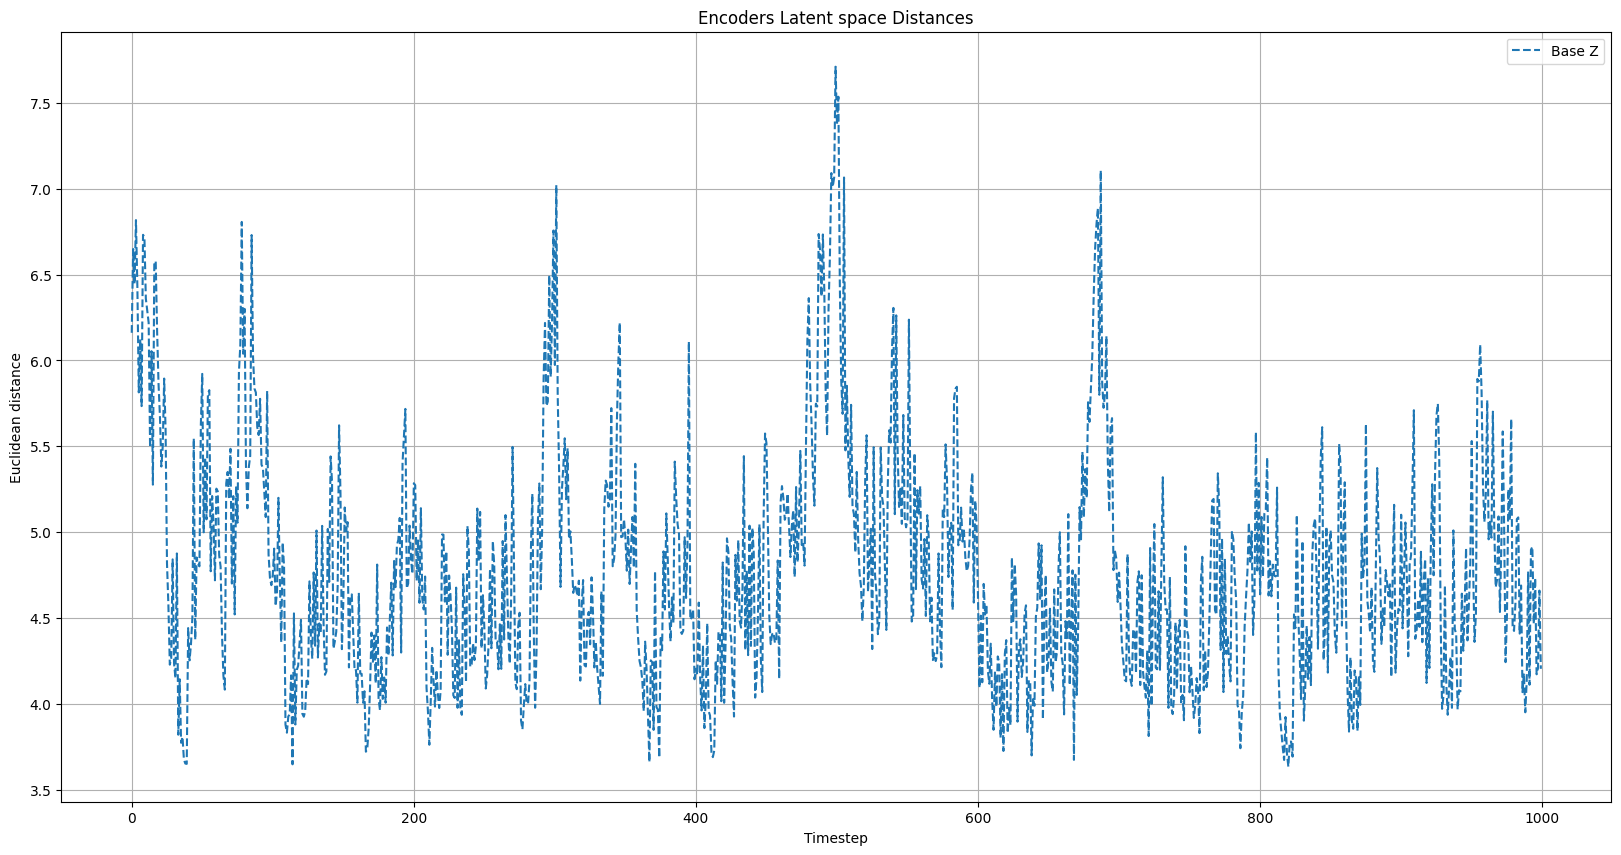

In [ ]:
import matplotlib.pyplot as plt

distances = []

for i in range(len(base_z)):
    distances.append(euclidean(base_z[i], adpt_z[i]))

print(distances)
indices = range(len(distances))

plt.figure(figsize=(20, 10))
plt.plot(indices, distances, label="Base Z", linestyle='--')

plt.xlabel("Timestep")
plt.ylabel("Euclidean distance")
plt.title(f"Encoders Latent space Distances")
plt.legend()
plt.grid(True)

plt.show()

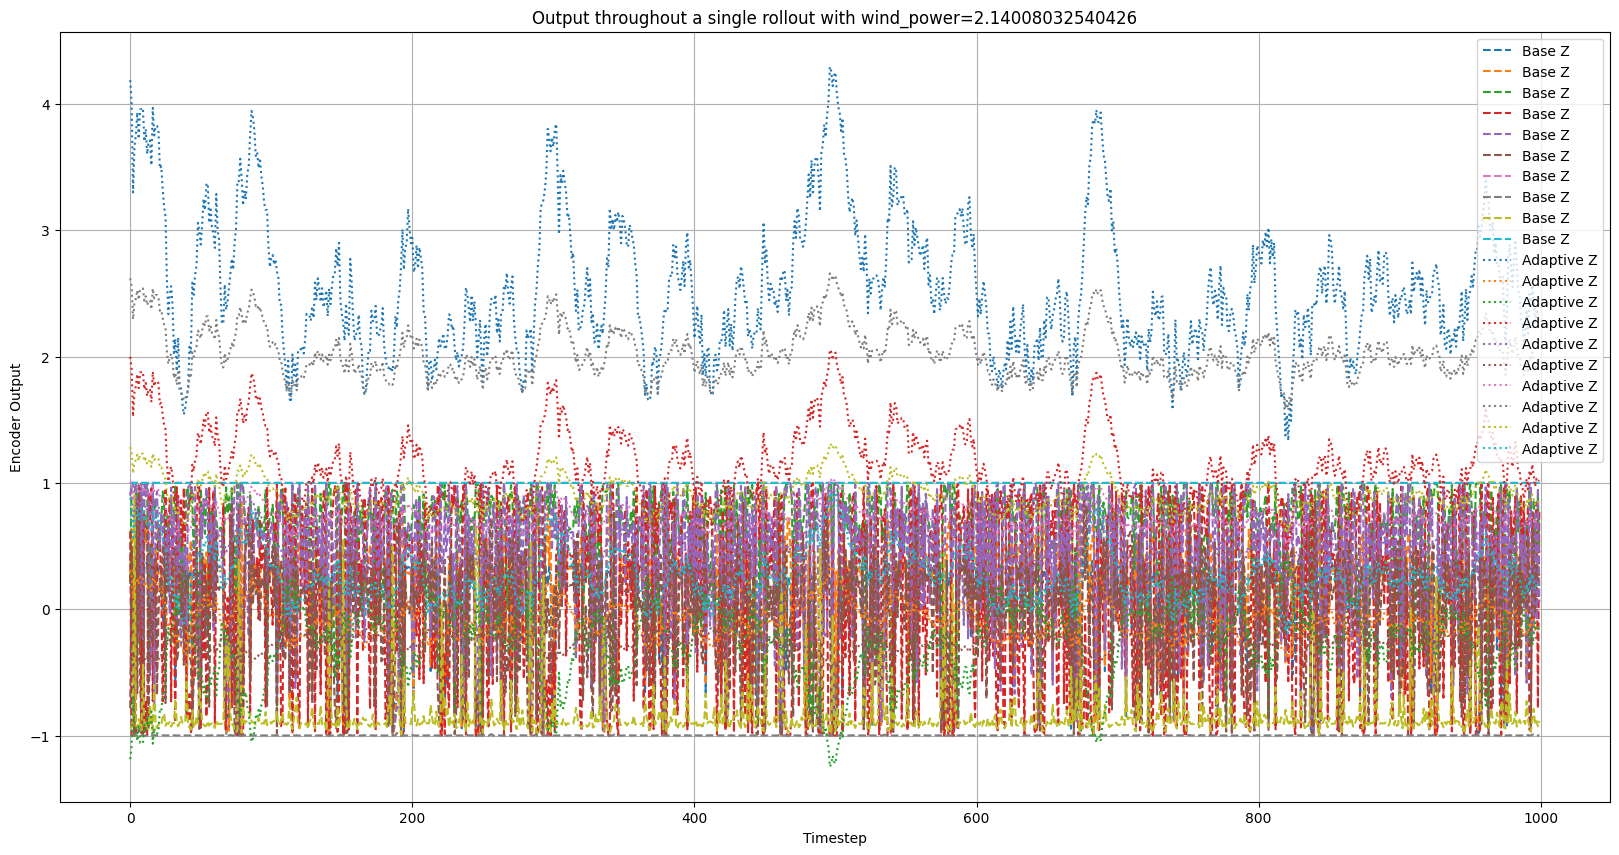

In [ ]:
import matplotlib.pyplot as plt

# wind_vals, base_z, adpt_z = ppo.validate_encoders_single_rollout()
indices = range(len(wind_vals))

plt.figure(figsize=(20, 10))
plt.plot(indices, base_z, label="Base Z", linestyle='--')
plt.plot(indices, adpt_z, label="Adaptive Z", linestyle=':')

plt.xlabel("Timestep")
plt.ylabel("Encoder Output")
plt.title(f"Output throughout a single rollout with wind_power={wind_vals[0]}")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
import numpy as np
t_winds, b_z, a_z = ppo.validate_encoders(100, 150)
sorted_indices = np.argsort(t_winds)
plt.figure(figsize=(8, 6))
plt.plot(t_winds[sorted_indices], b_z[sorted_indices], label="Base Z")
plt.plot(t_winds[sorted_indices], a_z.cpu().numpy()[sorted_indices], label="Adaptive Z", linestyle='--')

plt.xlabel("Indices")
plt.xlim(2, 10)
plt.ylabel("Values")
plt.title("Plot of True Z, Base Z, and Adaptive Z")
plt.legend()
plt.grid(True)

plt.show()

RuntimeError: The expanded size of the tensor (100) must match the existing size (1000) at non-singleton dimension 0.  Target sizes: [100].  Tensor sizes: [1000]